### Defining my threshold

Defining the success performance for my deep learning model. Accuracy is an important metric to use, representing the overall proportion of correctly classified instances. For this model to be considered successful, it should achieve a test accuracy of at least 80%, ensuring that the model generalizes well across unseen data. This threshold helps ensure that the model performs consistently, with minimal errors across the dataset.

However, i plan to also focus also precission score because accuracy may not provide a complete view of the model's performance. My model should aim for a precision and recall of at least 0.70 for each important class. A balanced precision.

Additionally, the confusion matrix should be examined to confirm that the model performs well across all classes and does not exhibit bias toward specific categories.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create the destination directory if it does not exist
#!mkdir -p '/content/dataset/'


In [2]:
#unzipping my dataset
!unzip -q '/content/drive/MyDrive/speed_dataset.zip' -d '/content/my_dataset/'


In [3]:

import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
import numpy as np

In [4]:
# List the contents of my dataset directory to verify the structure
!ls /content/my_dataset/roadsign_dataset



new_test_set  test_set	train_set  val_set


In [5]:
#setting up my dataset path

# Set directory paths to my dataset
train_set_dir = '/content/my_dataset/roadsign_dataset/train_set/'
val_set_dir = '/content/my_dataset/roadsign_dataset/val_set/'
test_set_dir = '/content/my_dataset/roadsign_dataset/test_set/'

#to check the number of label in each set
import os
print(len(os.listdir(train_set_dir)))
print(len(os.listdir(val_set_dir)))
print(len(os.listdir(test_set_dir)))

5
5
5


### pre-processing my image

In [6]:


image_size = 100
# Function to load and preprocess images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [image_size, image_size])
    image = image / 255 # Normalize pixel values to [0, 1]
    return image, label

# Function to load image paths and labels
def load_image_paths_and_labels(directory):
    # Defining the class names in the specific order you want
    class_names = ['50km', '60km', '80km', '100km', 'stop']

    # Create the class-to-index mapping
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    image_paths = []
    labels = []

    # Load images and labels based on the defined class-to-index mapping
    for class_name in class_names:
        class_dir = os.path.join(directory, class_name)
        for image_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_indices[class_name])

    return image_paths, labels


I declared a preprocess_image function:
Loads image file: Uses tf.io.read_file to read the image file from my given path.

Decodes image: Converts the image into a usable format using tf.image.decode_jpeg, ensuring it has 3 color channels (RGB).

Resizes image: Changes the image size to 100x100 pixels

Normalizes pixel values: Divides the pixel values by 255 to scale them between 0 and 1

load_image_paths_and_labels function:
Defines class labels:

Maps class names to numeric labels: Assigns an index to each class.





### loading my image and pre-processing

In [7]:

# Loading image paths and labels for each set
train_image_paths, train_labels = load_image_paths_and_labels(train_set_dir)
val_image_paths, val_labels = load_image_paths_and_labels(val_set_dir)
test_image_paths, test_labels = load_image_paths_and_labels(test_set_dir)

# Converting to TensorFlow datasets
train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, test_labels))

# Apply preprocessing
train_ds = train_ds.map(preprocess_image).repeat().batch(20).shuffle(buffer_size=len(train_image_paths))
val_ds = val_ds.map(preprocess_image).repeat().batch(20)
test_ds = test_ds.map(preprocess_image).batch(20)



### displaying some of my images randomly

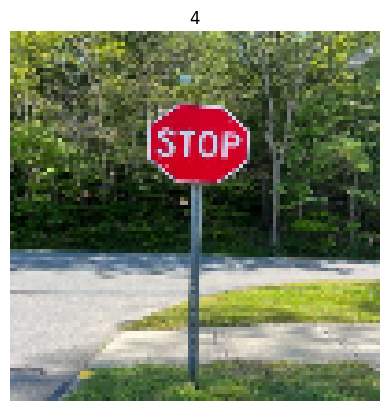

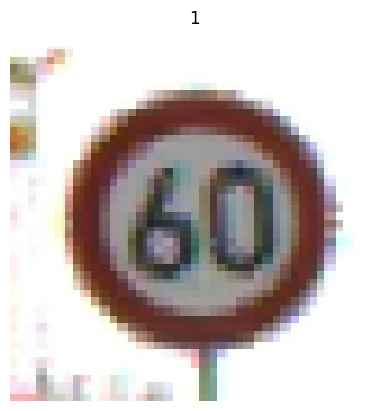

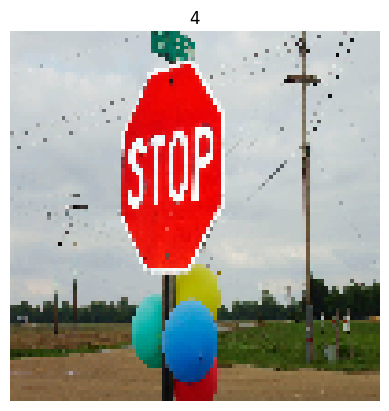

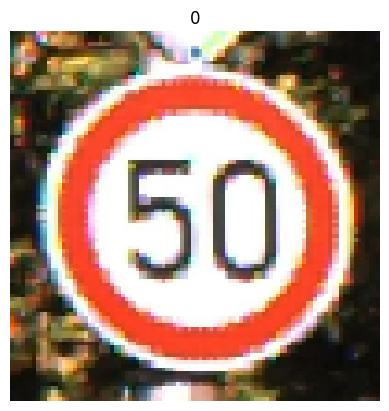

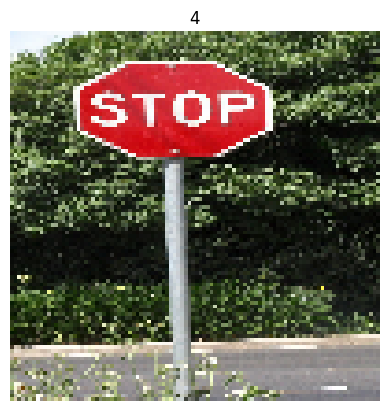

In [ ]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(label)
  plt.axis('off')
  plt.show()

# Display some images from the training dataset with numeric labels
for image, label in train_ds.take(5):
    show(image.numpy()[0], label.numpy()[0])


In [8]:
#defining the CNN model

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

def make_model():
    model = models.Sequential()

    # Convolutional base
    model.add(layers.Conv2D(256, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Dense head
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))  # for classification
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])

    return model

model = make_model()
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 98, 98, 256)         │           7,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 49, 49, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 47, 47, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 21, 21, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       3,277,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,655,877 (13.95 MB)

 Trainable params: 3,655,877 (13.95 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model = make_model()

history = model.fit(train_ds,
                    steps_per_epoch= 100,
                    epochs =30,
                    validation_data = val_ds,
                    validation_steps = 50)

#model.save('roadsign_model_2.h5')

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - acc: 0.3870 - loss: 1.5443 - val_acc: 0.3210 - val_loss: 1.3914
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.4478 - loss: 1.3553 - val_acc: 0.6190 - val_loss: 1.0857
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - acc: 0.5376 - loss: 1.2215 - val_acc: 0.6280 - val_loss: 0.9360
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - acc: 0.7274 - loss: 0.8027 - val_acc: 0.5230 - val_loss: 1.1233
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.6191 - loss: 0.9547 - val_acc: 0.7470 - val_loss: 0.7907
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.7035 - loss: 0.7520 - val_acc: 0.7340 - val_loss: 0.7643
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.6963 - loss: 0.8065 - val_acc: 0.7630 - val_loss: 0.6183
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - acc: 0.8320 - loss: 0.4887 - val_acc: 0.7480 - val_loss: 0.6745
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms

In [ ]:
#model.save('roadsign_model_1.h5')

In [ ]:
model.save('/content/drive/MyDrive/roadsign_model_1.h5')

In [9]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/roadsign_model_1.h5')

# Now you can evaluate or use it for predictions


In [19]:
!pip install git+https://github.com/tensorflow/docs
# Installs the tensorflow_docs module



  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-b8iviwhi
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-b8iviwhi
  Resolved https://github.com/tensorflow/docs to commit 98fa05949ba64f95c4df6565ea915a002a240289
  Preparing metadata (setup.py) ... done


(0.0, 1.0)

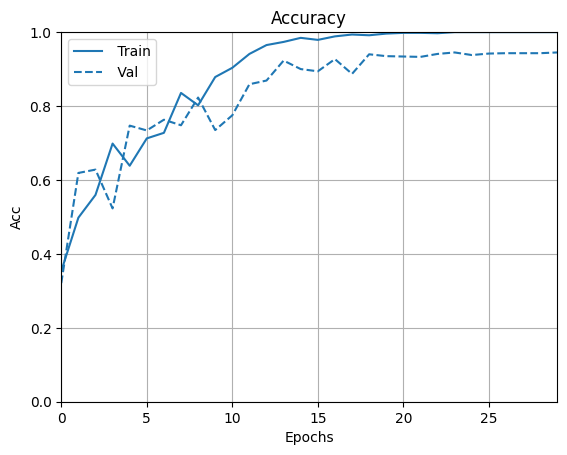

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

### accuracy Graph

With this accuracy plot, it shows that training and validation accuracy over 30 epochs. At the beginning, both training and validation accuracy improve steadily. After around 7 to 10 epochs, the training accuracy continues to increase, but the validation accuracy was kind of fluctuating slightly. With this it shows that the model begin to overfit after around 15 20 epochs. The validation accuracy remains stable but was not improving , while the training accuracy continues to rise, indicating that the model is learning more about the training data but is finding it difficult to generalizing better to unseen data.



(0.0, 1.0)

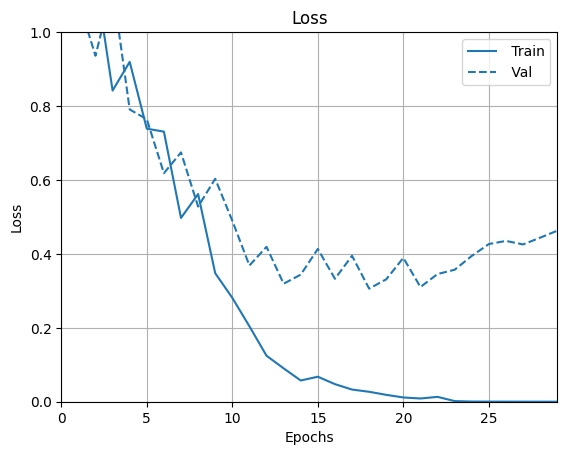

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": history}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

### loss graph
By plotting the loss plot for the above model i was able to get a more view of the model. Which shows how the model's training and validation loss changed over the training epochs.At the start, both the training and validation losses decrease rapidly, which indicates that the model is learning well during the early stages of training. On getting to the 10th epoch, the validation loss starts to fluctuate and later started  g increasing after the 15th epoch, while the training loss continues to decrease toward zero.

This behavior indicates overfitting. The model is learning to fit the training data very well, but it is no longer generalizing well to the validation data.

In [11]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - acc: 0.8500 - loss: 4.3922
Test Accuracy: 0.89


In [12]:
from sklearn.metrics import precision_score

# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Get true labels
    predictions = model.predict(images)  # Predict on the test images
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

# Calculate precision score for each class
precision_per_class = precision_score(y_true, y_pred, average=None)  # Remove 'average' to get precision for each class
print(f"Precision for each class: {precision_per_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Precision for each class: [0.         0.89285714 1.         0.875      0.91176471]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


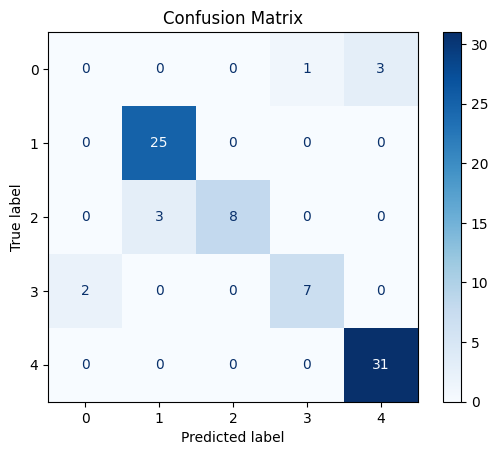

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Get true labels
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import precision_score

# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Get true labels
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate precision score
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Precision: {precision:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Precision: 0.87


### From My evaluation

Accuracy:

- My test accuracy is reported as 0.89 (89%). which actually indicates that my model is correctly classifying the majority of the test data. This is generally a good indicator of good performance, in my model in term of the accuracy result.
Precision:

- My precision score is gave me over all score of 0.87 (87%), meaning that out of all the instances my model predicted as a certain class, 87% of those

- In terms of the confusion matrix, it shows that my model performs well on certain classes, such as the 'Stop' class (class 4), where it predicted correctly 31 times. However, some classes like 80km (class 2) and 100km (class 3) have some errors. For example, the 80km sign was sometimes confused with 60km.

### My perfomance

1. Accuracy
My threshold for success is to achieve a test accuracy of at least 80%. From my result evaluation, the model achieved a test accuracy of 89%, which is more than my target threshold. This shows that the model is performing well and generalizes adequately on unseen data.

2. Precision
My threshold for a precision score is at least 0.70 for each class

though the overall weighted precision score is 0.87. which shows that the model is correctly identifying relevant instances with high precision. but in terms of diffrent classes

Class 0(50km): Precision is 0.0

Class 1(60km): Precision is 0.89

Class 2(80km): Precision is 1.0

Class 3(100km): Precision is 0.875

Class 4(stop): Precision is 0.91

from my precision score it hows that class 0(50km) is the only one below the threshold. which suggests that the model has not made any correct predictions for this class

In terms of confusion matrix:It shows that there are patterns of misclassification, which may indicates that there are signs with similar visual features

### over all perfomance

My model exceeds my accuracy threshold(80%) and also perform well in the over all precision

From the evaluation of the above model, the results show that the model was able to achieve a test accuracy of 89% on the test dataset, which indicates that the model is performing well in predicting unseen data. However, from the loss result it shows the test loss is quite high at 4.392, which indicates that while the model is predicting some  right classes in some  cases, it is also be making some wrong prediction in some cases

### Using augmentation to improve the Model

In [12]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    image = tf.image.random_hue(image, max_delta=0.1)


    # Ensure final resize to model input size
    image = tf.image.resize(image, [image_size, image_size])  # Resize to 150x150

    return image, label




### My Augumentation pipeline

1.Conversion to Float Type and Normalization: This helps to convert the image to float32

2.Random Horizontal and Vertical Flip
This helps to randomly flips the image horizontally and vertiaclly during training

3.Random brightness adjustment:
This helps to adjust the brightness of the image randomly within my define range max_delta=0.1, it helps to simulate varying lghtning conditions of the image

4.Random contrast Adjustment
It helps to adjust the contrast of the image by improving or reducing the contrast. In my case the range was defined as(0.8 t0 1.2)

5.Random saturation:
it helps to modify the saturation of the image within a specified range. in my case it was specified as (0.8 to 1.2)

6.Random Hue:
it helps to change the hue(color tone) of the image by a defined amount. in my cas max_delta=0.1

7.resizing the image:
ensuring the image was resized to the correct dimension.


In [13]:
# Applying data augmentation to the training dataset without double batching
train_ds_aug = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=len(train_image_paths)).prefetch(tf.data.AUTOTUNE)

# Validation dataset remains unchanged
val_ds_aug = val_ds


In [25]:
import tensorflow as tf
import time
import matplotlib.pyplot as plt

# Define the custom callback to track time
class TimeCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        self.start_time = time.time()

    # This function runs at the end of each epoch
    def on_epoch_end(self, epoch, logs=None):
        current_time = time.time()
        time_elapsed = current_time - self.start_time
        self.times.append((epoch + 1, time_elapsed))

    # This function runs at the end of training
    def on_train_end(self, logs=None):
        epochs, total_times = zip(*self.times)
        plt.figure(figsize=(8, 6))
        plt.plot(epochs, total_times, marker='o')
        plt.xlabel('Epoch')
        plt.ylabel('Cumulative Time (seconds)')
        plt.title('Total Time Taken to Train Up to Each Epoch')
        plt.grid(True)
        plt.show()

model = make_model()

# Define the custom callback
time_callback = TimeCallback()



Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 62s 61ms/step - acc: 0.2766 - loss: 1.5791 - val_acc: 0.5550 - val_loss: 1.3505
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - acc: 0.4724 - loss: 1.3365 - val_acc: 0.5810 - val_loss: 1.1407
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.5741 - loss: 1.1312 - val_acc: 0.5690 - val_loss: 1.0295
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - acc: 0.5783 - loss: 1.0534 - val_acc: 0.6630 - val_loss: 0.8903
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.6074 - loss: 0.9548 - val_acc: 0.6290 - val_loss: 0.8356
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - acc: 0.6680 - loss: 0.9914 - val_acc: 0.6720 - val_loss: 0.8483
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.6942 - loss: 0.9138 - val_acc: 0.7360 - val_loss: 0.7626
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.6854 - loss: 0.8262 - val_acc: 0.7320 - val_loss: 0.7326
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms

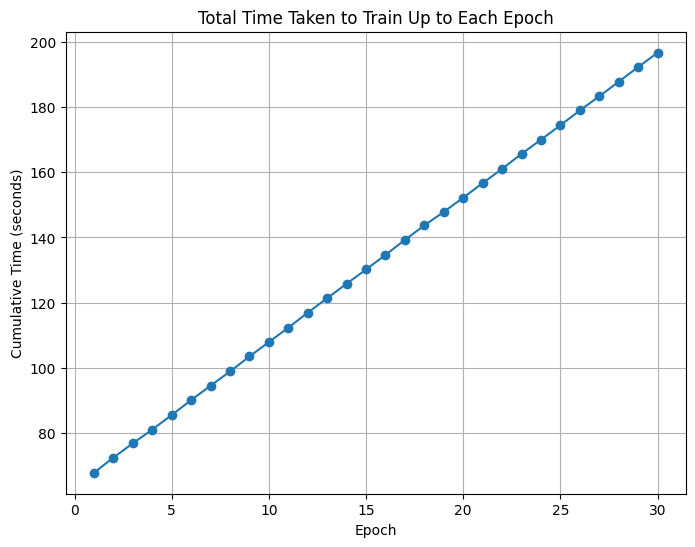

In [26]:
aug_history = model.fit(
    train_ds_aug,
    steps_per_epoch=100,
    epochs=30,
    validation_data=val_ds_aug,
    validation_steps=50,
    callbacks=[time_callback]
)

From this graph, it shows the total time it took to train the model over several epochs, and the time increases steadily. This means that each epoch (or training step) takes about the same amount of time to complete, without any delays or slowdowns

In [ ]:
model.save('/content/drive/MyDrive/aug_model_2.h5')

In [22]:
from tensorflow.keras.models import load_model


model = load_model('/content/drive/MyDrive/aug_model_2.h5')

(0.0, 1.0)

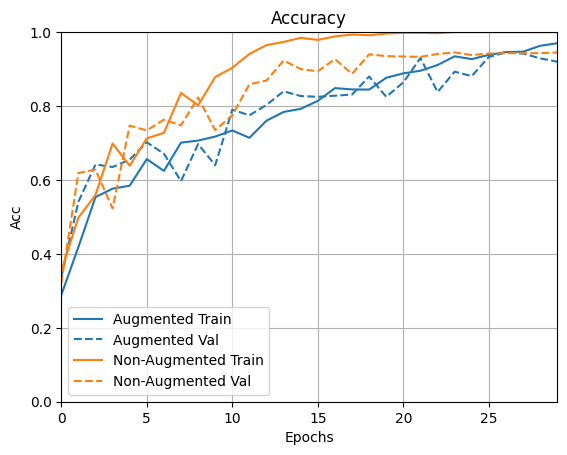

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots


plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

Augumented and non-augumented accuracy graph

This graph shows how my model performs with and without data augmentation. For the non-augmented data (orange lines), the model quickly reaches high accuracy but starts overfitting around 10 epochs, which means it perform well on the training data but but not the on validation data. This is a sign that the model is learning too much from the specific training examples without generalizing well.

On the other hand, the augmented data (blue lines) shows more balanced learning. The accuracy improves more slowly and stays stable across both training and validation data around 25 epochs. This indicates that the model generalizes better, even though it takes longer to reach a high level of accuracy.

Text(0.5, 1.0, 'loss')

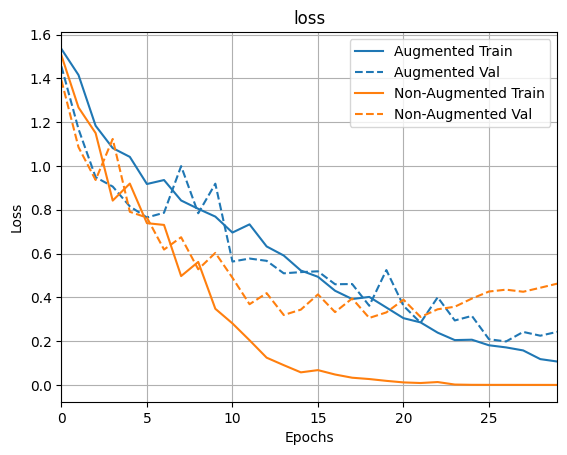

In [ ]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non-Augmented": history}, metric = "loss")
plt.title("loss")

### agugument and non- augumented loss graph

In this graph the non-augmented data (orange lines), the training loss decreases sharply , showing that the model is quickly learning the training data well. However, at aroun 10 epoch the validation loss starts to fluntuate and later began to increase, indicating overfitting.

For the augmented data (blue lines), the training loss decreases more steadily and does not drop as quickly. The validation loss for the augmented set were more stable, showing less overfitting and better generalization. This indicates that the model was able to learn well for data augmentation

In [16]:

# Evaluate the model on the test set after training with augmented data
test_loss_augmented, test_acc_augmented = model.evaluate(test_ds)
print(f"Test Accuracy with Data Augmentation: {test_acc_augmented:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - acc: 0.8717 - loss: 1.5820 
Test Accuracy with Data Augmentation: 0.91


In [17]:
from sklearn.metrics import precision_score

# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Get true labels
    predictions = model.predict(images)  # Predict on the test images
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate precision score for each class
precision_per_class = precision_score(y_true, y_pred, average=None)

# Print precision for each class
for class_idx, precision in enumerate(precision_per_class):
    print(f"Class {class_idx} Precision: {precision:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Class 0 Precision: 0.00
Class 1 Precision: 0.93
Class 2 Precision: 0.90
Class 3 Precision: 1.00
Class 4 Precision: 0.91


In [ ]:

from sklearn.metrics import precision_score

# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())  # Get true labels
    predictions = model.predict(images)  # Predict on the test images
    y_pred.extend(np.argmax(predictions, axis=1))  # Get predicted labels

# Calculate precision score
precision_augmented = precision_score(y_true, y_pred, average='weighted')  # You can use 'macro', 'micro', or 'weighted'
print(f"Precision with Data Augmentation: {precision_augmented:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Precision with Data Augmentation: 0.88


In [ ]:
performance_gain = test_acc_augmented - test_acc
print(f"Performance Gain with Data Augmentation: {performance_gain:.2f}")


Performance Gain with Data Augmentation: 0.03


### Model evaluation
In terms off accuarcy my model was evaluated on the test set as 91% after training with data augmentation. This  shows an improvement over the earlier test accuracy without augmentation of 89%.

In terms of precision
The precision score for each class is reported as:

Class 0 Precision: 0.00

Class 1 Precision: 0.93

Class 2 Precision: 0.90

Class 3 Precision: 1.00

Class 4 Precision: 0.91.

And the overall precision with augmentation is 88%. This also shows an improvement over the earlier test accuracy without augmentation of 87%.

### In terms of the performance gain

I calculated the performance gain in accuracy by subtracting the accuracy without augmentation (test_acc) from the accuracy with augmentation (test_acc_augmented). The reported performance gain is 3%(0.03)

After adding data augmentation, the model's test accuracy increased from 0.89 to 0.91,  This means that the model became slightly better at handling new, unseen data. Even though the improvement is small, it shows that data augmentation helped the model avoid overfitting and learn more effectively by using a wider variety of training examples.

## Task 2.2 Profilling of input using the graph above and the time per eopch

From my profiling results it showed that most of the time was spent on loading and preparing the data, while less time was spent on the actual computation because I used a powerful GPU(google colab pro), which handled the training efficiently.

I was able to address the slow data loading by application of:

Auto-tuning Data Loading: I used AUTOTUNE to automatically set the best number of processes to load and prepare data in parallel, making it faster.

Prefetching: I added prefetching to make sure the next batch of data is ready while the current one is being processed, reducing waiting time.

### 2.2

### calculating the number of epochs needed to be added

After calculating the total training time for my non augumented model through time per epoch, I got 134secs and for the augumented model is 200secs which was done by adding all the time per epochs together. The difference between them is

non_Augmented 134secs - augumented 200secs = 36secs

To balance it, im trying to add small number of epoch to the non-augumented model
using this formular

134(non_augumented) + 200(augumneted) = 334
334/2= 167secs

average time per epoch = 167secs/number of epoch
167/30 = 5.56secs

extra epochs = 30/average time per epoch
66/5.56 = 11.8epochs ~ 12epochs


### retraining the non-augumented model to match the same training time with the augumented epoch by adding to its number of epoch

#### Adding 12 epochs more to the non_augumented model



In [16]:
model = make_model()

history_equal_time = model.fit(train_ds,
                    steps_per_epoch= 100,
                    epochs =42, # +12 epochs
                    validation_data = val_ds,
                    validation_steps = 50)

Epoch 1/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - acc: 0.2654 - loss: 1.6031 - val_acc: 0.4150 - val_loss: 1.3391
Epoch 2/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.5193 - loss: 1.2062 - val_acc: 0.6590 - val_loss: 1.0911
Epoch 3/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.5379 - loss: 1.1970 - val_acc: 0.6200 - val_loss: 0.9810
Epoch 4/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - acc: 0.6701 - loss: 0.9308 - val_acc: 0.6200 - val_loss: 0.7952
Epoch 5/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.6672 - loss: 0.8832 - val_acc: 0.7550 - val_loss: 0.6962
Epoch 6/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.7606 - loss: 0.6976 - val_acc: 0.6190 - val_loss: 0.8500
Epoch 7/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - acc: 0.7625 - loss: 0.6571 - val_acc: 0.8170 - val_loss: 0.5913
Epoch 8/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - acc: 0.8554 - loss: 0.4465 - val_acc: 0.8340 - val_loss: 0.4614
Epoch 9/42
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms

In [17]:
model.save('/content/drive/MyDrive/history_equal_time_1.h5')

In [18]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('/content/drive/MyDrive/history_equal_time_1.h5')



(0.0, 1.0)

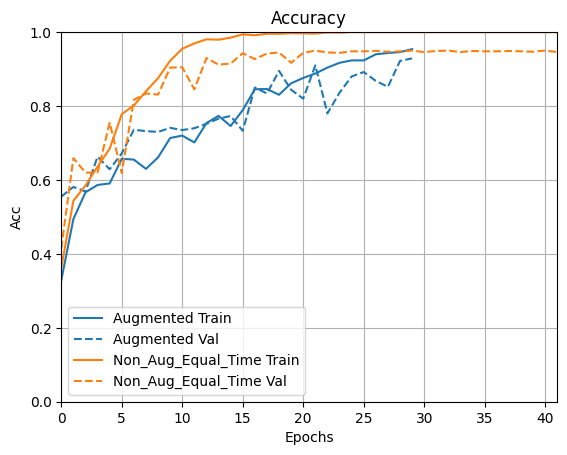

In [30]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non_aug_equal_time": history_equal_time}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

(0.0, 1.0)

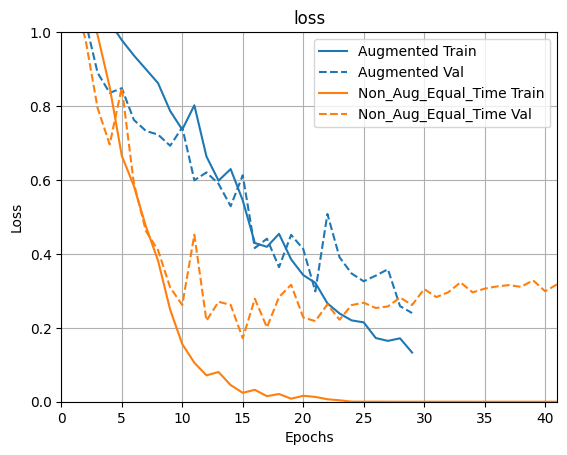

In [27]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({ "Augmented": aug_history, "Non_aug_equal_time": history_equal_time}, metric = "loss")
plt.title("loss")
plt.ylim([0,1])

### The accuracy graph

The model without augmentation (orange lines) achieves higher initial accuracy, both in training and validation. However,as it gets to 10 epoch it starts to fluntuate and later began to overfit. As the training progresses, the augmented model (blue lines) shows consistent improvement and eventually matches the performance of the non-augmented model. This suggests that while augmentation introduces variability and slows initial convergence, it helps the model generalize better, especially in more complex scenarios.

### The loss graph

In the loss graph, the non-augmented model achieves lower training and validation loss faster than the augmented model while the augmented model's loss decreases steadily and shows signs of stabilizing at a low value, while the non-augmented model’s validation loss fluctuates, and later began to overfit around 30 epoch

Despite the addition of 12 epochs to the non-augmented model for extended training, the model  is still not generalizing as well as expected.

Evaluating there performance

In [21]:
# Evaluate model without augmentation
test_loss_no_aug, test_acc_no_aug = model.evaluate(test_ds)
print(f"Test Accuracy without Data Augmentation: {test_acc_no_aug:.2f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - acc: 0.8500 - loss: 3.9182
Test Accuracy without Data Augmentation: 0.89


In [ ]:
# Get the true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate precision score
precision_no_aug = precision_score(y_true, y_pred, average='weighted')  # You can use 'macro', 'micro', or 'weighted'
print(f"Precision without Data Augmentation: {precision_no_aug:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Precision without Data Augmentation: 0.88


In [ ]:

# Compare performance
performance_gain_equal_time = test_acc_augmented - test_acc_no_aug
print(f"Performance Gain with Data Augmentation: {performance_gain_equal_time:.2f}")

Performance Gain with Data Augmentation: 0.03


### It's performance

After adding 12 more training epochs to the model without data augmentation, there was no improvement in performance. The accuracy stayed at 89%, indicating that the model had reached its learning capacity with the current data and setup. Adding more training time didn’t result in any gains, which indicates that the model had already captured all the patterns it could from the training set.

Besides, the precision score also remained at 88%, which further supports the observation that adding extra training epochs didn't improve the non augumented model ability to correctly classify the class correctly

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
Number of misclassified images: 9


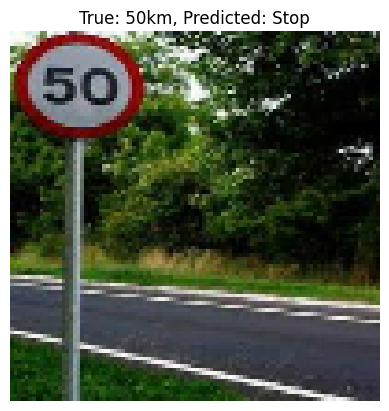

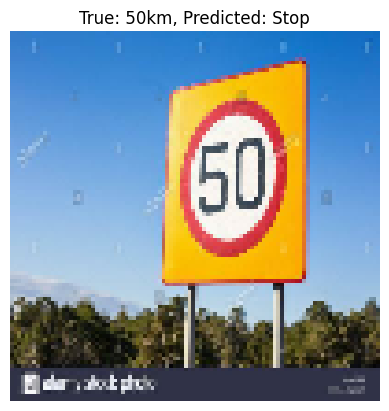

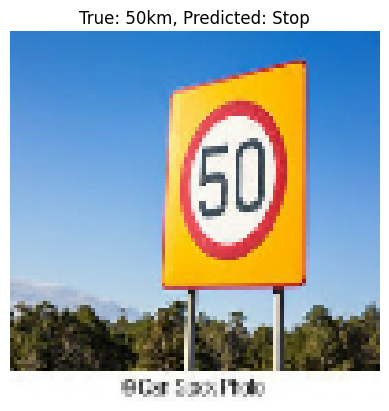

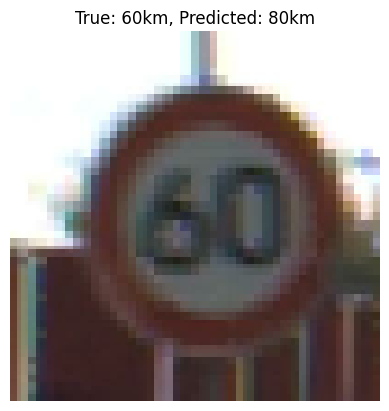

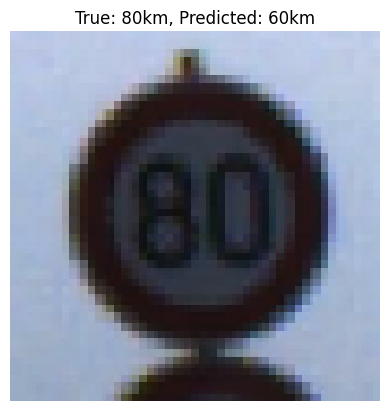

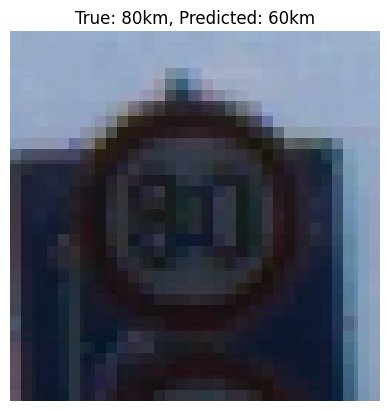

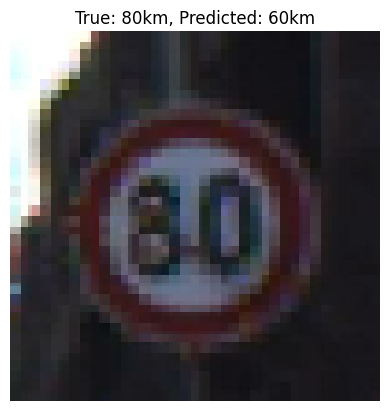

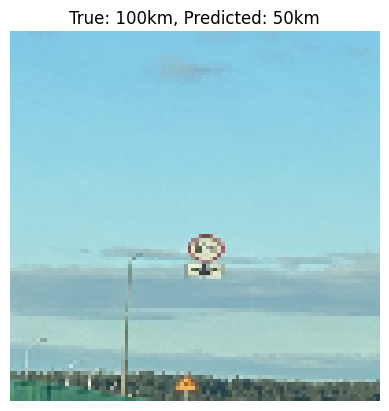

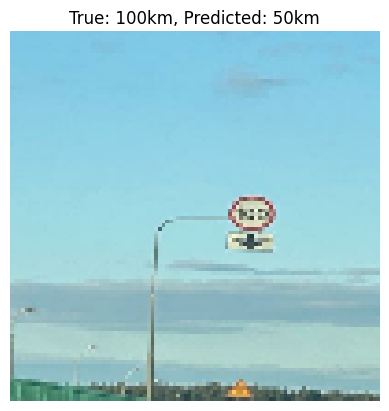

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# images and labels from the test dataset
images_list = []
labels_list = []

for images_batch, labels_batch in test_ds:
    for image, label in zip(images_batch.numpy(), labels_batch.numpy()):
        images_list.append(image)
        labels_list.append(label)

images_array = np.array(images_list)
labels_array = np.array(labels_list)

# Getting true labels and predictions
true_labels = labels_array
predictions = np.argmax(model.predict(test_ds), axis=1)

# Identifying misclassified indices
misclassified_indices = np.where(predictions != true_labels)[0]

print(f"Number of misclassified images: {len(misclassified_indices)}")

# the function to display misclassified images
def display_misclassified_images(images, true_labels, predictions, misclassified_indices, class_names):
    for idx in misclassified_indices[:10]:  # Display the first 5 misclassified images
        image = images[idx]
        true_label = true_labels[idx]
        predicted_label = predictions[idx]

        plt.figure()
        plt.imshow(image)
        plt.title(f"True: {class_names[true_label]}, Predicted: {class_names[predicted_label]}")
        plt.axis('off')
        plt.show()

#  Prepare class names
class_names = ['50km', '60km', '80km', '100km', 'Stop']  # Adjust based on your class indices

# function call
display_misclassified_images(images_array, true_labels, predictions, misclassified_indices, class_names)



### Do they share something in common

Yes, the misclassified images share some common features. Out of the 9 misclassified images, some percentages are from the "50km" class, and they were all incorrectly predicted as "Stop" some are from 60km, which are misclassified as 80km, some 100km are also misclassified as stop signs.

One reason i think is maybe as a result of the visibilty of poles holding the signs in all of these listed images, which might confuse the model. The model may be focusing on the pole rather than the actual sign, leading to the wrong prediction.

Another reason could be the background in these images. Many of the misclassified  signs have similar backgrounds, such as trees and bushes, which may be causing the model to mix up the "50km" signs with "Stop" signs.

### I plan to improve the model

- Improve the data augumentation:

 I aim to improve the model applying more advanced augmentation techniques such as random cropping, rotation, zoom, and brightness/contrast adjustments. These techniques will expose the model to a variety of variations, forcing it to focus on the essential features of the road signs rather than the surroundings or poles holding the signs.

- Introducing dropout regularization

 I will introduce a dropout regularization layer into the augmented model.This will help prevent the model from focusing too much on unnecessary details, like poles or backgrounds. This will help the model learn better and be less likely to make mistakes when it sees new images.

- Fine-tuning the Model:
  Tweaking the learning rate, adding more convolutional layers, and adjusting batch normalization. Doing that i believe it will help the model to capture more complex patterns in the images.

-  Class Balancing:
  By adding more data to the classes that are underrepresented well, classes which the model struggles to classify very well.
  this involves adjusting the dataset to ensure that each class has a similar number of samples, which helps the model learn to classify all classes more accurately expecially using oversampling(adding more data to the classes).



### Section 3(D)

For thsi section i gathered a new set of test data by scraping images from the internet, like we were told. Focusing on those images with higher levels of variation. These images include noisier examples, diverse backgrounds, and were captured using different mobile phones and cameras.

### setting path loading and pre-processing my new test set

In [39]:
# Set directory paths for the new test dataset
new_test_set_dir = '/content/my_dataset/roadsign_dataset/new_test_set/'

# Load image paths and labels for the new test set
new_test_image_paths, new_test_labels = load_image_paths_and_labels(new_test_set_dir)

# Convert to TensorFlow datasets
new_test_ds = tf.data.Dataset.from_tensor_slices((new_test_image_paths, new_test_labels))

# Apply preprocessing
new_test_ds = new_test_ds.map(preprocess_image).batch(32)

### showing some images from my formal test set and new test set

In [27]:
import matplotlib.pyplot as plt

# Function to display images in a grid with their labels
def show_images_in_grid(images, labels, num_rows=1, num_cols=5):
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.show()

# Function to extract one image per class from the dataset
def extract_images_per_class(dataset, num_classes=5):
    class_images = {}
    class_labels = {}

    # Iterate through the dataset and sample one image per class
    for image, label in dataset.unbatch():
        label_value = int(label.numpy())
        if label_value not in class_images:
            class_images[label_value] = image
            class_labels[label_value] = label_value
        if len(class_images) == num_classes:
            break

    # Collect the images and labels for displaying
    images_list = [img.numpy() for img in class_images.values()]
    labels_list = list(class_labels.values())

    return images_list, labels_list



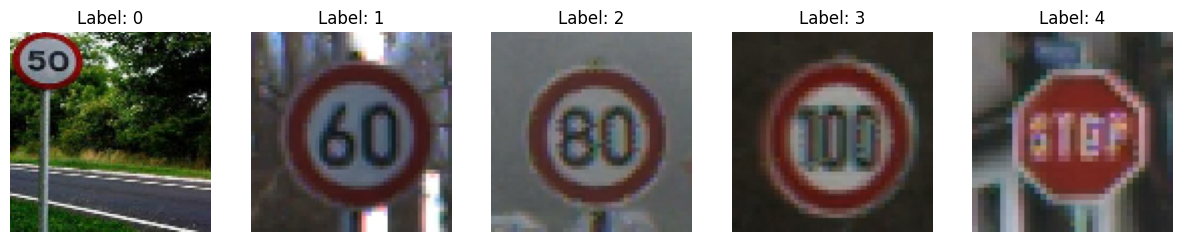

In [ ]:

# Using the function to extract images from the test_ds
images_list, labels_list = extract_images_per_class(test_ds)
show_images_in_grid(images_list, labels_list, num_rows=1, num_cols=5)

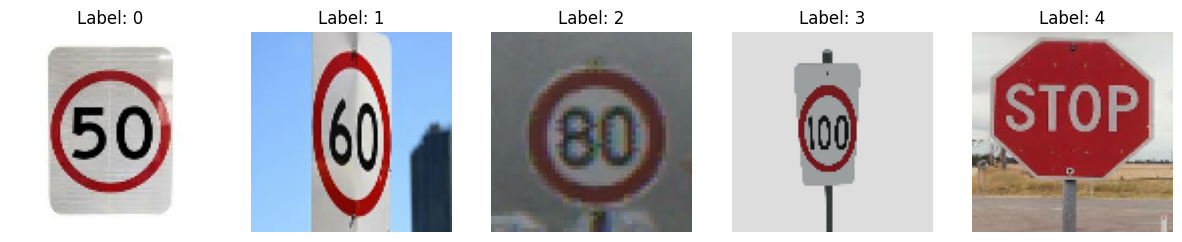

In [ ]:
#using the function with new_test_ds
new_images_list, new_labels_list = extract_images_per_class(new_test_ds)
show_images_in_grid(new_images_list, new_labels_list, num_rows=1, num_cols=5)


### The comparison between the two test sets of images shows are:

The original test images(test_ds) tend to be closer to the camera and somewhat blurry, which could make it harder for the model to recognize certain features. On the other hand, the new test images(new_test_ds) that were collected are more clear, with sharper and more precise details, likely providing a better visual representation of the road signs

### feeding the new test data into my model

In [ ]:
# Evaluating the model on the new test dataset
new_test_loss, new_test_accuracy = model.evaluate(new_test_ds)
print(f"Model Accuracy on New Test Data: {new_test_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - acc: 0.6000 - loss: 9.5502
Model Accuracy on New Test Data: 0.60


In [33]:
from sklearn.metrics import precision_score
import numpy as np

# Get the true labels and predictions for the new test dataset
y_true = []
y_pred = []

# Loop through the new test dataset and collect true labels and predictions
for images, labels in new_test_ds:
    y_true.extend(labels.numpy())  # True labels
    predictions = model.predict(images)  #
    y_pred.extend(np.argmax(predictions, axis=1))  #

# Convert the lists to numpy arrays for precision calculation
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate the precision for each class using sklearn
precision_per_class = precision_score(y_true, y_pred, average=None)

# Print precision for each class
for i, precision in enumerate(precision_per_class):
    print(f"Class {i} Precision: {precision:.2f}")

# Calculate the overall weighted precision
overall_precision = precision_score(y_true, y_pred, average='weighted')
print(f"Overall Precision on New Test Data: {overall_precision:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
Class 0 Precision: 1.00
Class 1 Precision: 1.00
Class 2 Precision: 0.67
Class 3 Precision: 0.00
Class 4 Precision: 0.42
Overall Precision on New Test Data: 0.64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluating the model on the original test dataset
original_test_loss, original_test_accuracy = model.evaluate(test_ds)
print(f"Model Accuracy on Original Test Data: {original_test_accuracy:.2f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - acc: 0.8500 - loss: 4.0785
Model Accuracy on Original Test Data: 0.89


In [ ]:
# Calculate the performance change
performance_change = new_test_accuracy - original_test_accuracy
print(f"Performance Change: {performance_change:.2f}")


Performance Change: -0.29


After evaluating the model with the new test dataset, the model's accuracy dropped to 60% having  -29% decreament compare to the intial test accuracy

In terms of precision per class
- Class 0 (50 km/h): 1.00

- Class 1 (60 km/h):1.00

- Class 2 (80 km/h):0.67

- Class 3 ( 100 km/h): 0.00

- Class 4 (Stop Sign):  0.42

initially, the model performed well on the original test data, achieving 89% accuracy, which means it could correctly classify most images from that dataset. So, when tested on a new set of images with more noise, different backgrounds, that was downloaded  the model accuracy dropped to 60%. This shows that the model has problem dealing with more challenging images

In terms of the precision scores, it also show that the model was very accurate for some classes, like "Speed Limit 50km" and 60km, but struggled with others. For example, it couldn't correctly classify any of the 100km signs (precision of 0.00) and had trouble with "Stop Sign" (precision of 0.42). This drop in performance suggests that while the model did well on data similar to what it was trained on, it needs improvement to handle more diverse and noisy data effectively

#### Improving the model

### My process of improving the model, for it ability to generalize well across different data variations.

Firstly,I performed a more advanced data augmentation on the training datasets. This technique helps the model become more robust by introducing random changes to the images, I intoduced method such as flipping, adjusting brightness, contrast, saturation, and hue while giving them a higher range compare to my first augumentation and hue. By doing this, the model was able to learns to recognize road signs even when the images have slight variations in lighting, orientation, or color.

After that, I introduced a more complex model architecture was introduced, with additional convolutional layers and batch normalization. which made up of total 16layers
- Batch normalization in this process was used to help the model train faster and stabilize learning by normalizing the input layer for each mini-batch.

- Dropout layers were also added to prevent overfitting and ensuring that the model doesn’t rely too much on specific neurons, helping it perform better on unseen data.

Finally, For me to able able to monitor and control the training process, callbacks like early stopping, model checkpointing, and learning rate reduction were added.

- Early stopping prevents overfitting by stopping the training when the validation loss doesn’t improve for a few epochs.

- Model checkpoints saved the best version of the model, ensuring that even if training continued, the best-performing model is kept.

- Reducing the learning rate during plateaus allowed the model to fine-tune weights more effectively.

I used all these combined to build a more reliable and generalizable model.

Starting with a data agumentation

In [ ]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, 1, 2)
    image = tf.image.random_hue(image, 0.3)


    # final resize to model input size
    image = tf.image.resize(image, [image_size, image_size])

    return image, label




In [ ]:
# Applying data augmentation to the training dataset without double batching
new_train_ds_aug_1 = train_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=len(train_image_paths)).prefetch(tf.data.AUTOTUNE)

# Validation dataset remains unchanged
new_val_ds_aug_1 = val_ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=len(train_image_paths)).prefetch(tf.data.AUTOTUNE)




In [ ]:
from tensorflow.keras import models, layers, optimizers

def model_with_batch_dropout():
    model = models.Sequential()

    model.add(layers.Conv2D(256, (7, 7), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))

    model.add(layers.Conv2D(64, (2, 2), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output and add Dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))

    # Fully connected layer with Dropout
    model.add(layers.Dense(1028, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.2))

    # Output layer for 5 classes
    model.add(layers.Dense(5, activation='softmax'))

    # Compile the model
    model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model




In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model_3 = model_with_batch_dropout()

# Early stopping to stop training when validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model during training
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

# Reduce learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history_3 = model_3.fit(
    new_train_ds_aug_1,
    epochs=30,
    validation_data=new_val_ds_aug_1,
    steps_per_epoch=100,
    validation_steps=50,
    callbacks=[early_stopping, checkpoint, reduce_lr]
)




Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


100/100 ━━━━━━━━━━━━━━━━━━━━ 99s 403ms/step - accuracy: 0.2709 - loss: 1.6409 - val_accuracy: 0.5390 - val_loss: 1.4799 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.6667 - loss: 0.8731 - val_accuracy: 0.7720 - val_loss: 1.2979 - learning_rate: 1.0000e-04
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 229ms/step - accuracy: 0.7669 - loss: 0.6540 - val_accuracy: 0.7200 - val_loss: 1.0716 - learning_rate: 1.0000e-04
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.8164 - loss: 0.4991 - val_accuracy: 0.6630 - val_loss: 0.9066 - learning_rate: 1.0000e-04
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 222ms/step - accuracy: 0.8907 - loss: 0.3245 - val_accuracy: 0.8510 - val_loss: 0.4705 - learning_rate: 1.0000e-04
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 212ms/step - accuracy: 0.9360 - loss: 0.1845 - val_accuracy: 0.7210 - val_loss: 0.8492 - learning_rate: 1.0000e-04
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 213ms/step - 

(0.0, 1.0)

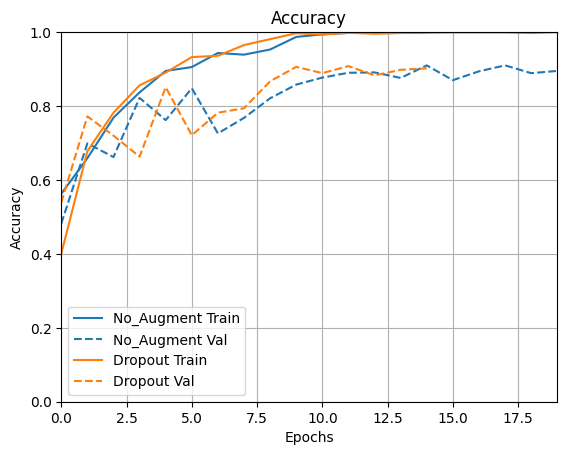

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"no_augment": history,  "Dropout": history_3}, metric = "accuracy")
plt.title("Accuracy")
plt.ylim([0,1])


Both models quickly learned the training data, reaching nearly 100% accuracy. However, around the 5th epoch, the validation accuracy of both models began to fluctuate, indicating that the models were struggling to generalize well to unseen data. At around the 6th epoch, both models started showing signs of overfitting, where their performance on the validation set started to decline or stabilize while the training accuracy remained high.

The model trained without (drop out) stopped training earlier due to the callback method, which was applied to stop training when the model no longer improved. This suggests that the model had reached its peak level of generalization by that point, and continuing to train would have caused it to overfit further

(0.0, 1.0)

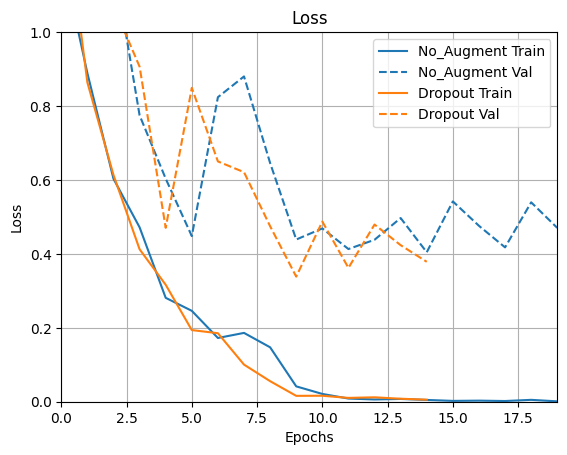

In [ ]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"no_augment": history,  "Dropout": history_3}, metric = "loss")
plt.title("Loss")
plt.ylim([0,1])

For this loss graph, around the 5th epoch, the validation loss for both models began to fluctuate significantly. This indicates that the models started having difficulty generalizing to the validation data at this point.

The "No_Augment" model, marked by the blue dashed line, shows more dramatic fluctuations in validation loss, which is a sign that it was overfitting as it struggled to generalize.
in terms of the dropout it stopped training around the 13th epoch because, if it had continued, it would likely have resulted in more overfitting. We can see that after the 5th epoch, the validation loss began to fluctuate, indicating that the model was starting to struggle with generalizing to new data

In [ ]:
# Evaluating the model on the new test dataset
updated_new_test_loss, updated_new_test_accuracy = model_3.evaluate(new_test_ds)
print(f"Model Accuracy on New Test Data: {updated_new_test_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6000 - loss: 2.8505
Model Accuracy on New Test Data: 0.60


In [ ]:
import numpy as np
from sklearn.metrics import precision_score

# Make predictions on the test dataset
y_true = []
y_pred = []

# Loop over the test dataset to collect true labels and predictions
for images, labels in new_test_ds:
    predictions = model_3.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())  # True labels
    y_pred.extend(predicted_classes)  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision using sklearn
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision on New Test Data: {precision:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
Precision on New Test Data: 0.65


In [29]:
import numpy as np
from sklearn.metrics import precision_score

# Make predictions on the test dataset
y_true = []
y_pred = []

# Loop over the test dataset to collect true labels and predictions
for images, labels in new_test_ds:
    predictions = model_3.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Get the predicted class labels
    y_true.extend(labels.numpy())  # True labels
    y_pred.extend(predicted_classes)  # Predicted labels

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision for each class
precision_per_class = precision_score(y_true, y_pred, average=None)  # No 'average' to get per-class precision

# Print precision for each class
for class_idx, precision in enumerate(precision_per_class):
    print(f"Class {class_idx} Precision: {precision:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
Class 0 Precision: 0.75
Class 1 Precision: 0.33
Class 2 Precision: 0.60
Class 3 Precision: 1.00
Class 4 Precision: 0.57



After attempting to improve the model through the above methods, the overall model accuracy remained at 60%, but the precision was able to slightly increase by 1%, moving from 64% to 65%.

In terms of the precision per class

- Class 0 precision decreased from 1.00 to 0.75, this maybe as a result of the model’s increased complexity or the augmented data introducing more challenging examples

- Class 1 precision reduced from 1.00 to 0.33, this may be indicating that the class might need more examples or further adjustments to handle better.

- Class 3 precision improved from 0.00 to 1.00, indicating that the changes helped the model to better recognize this class.

From the result from the precision across diffrent classes suggest that the model is learning to recognize some classes better


### Reasons which might have affected my methods not to generalize well

- Data Augumentation
if the resulted augmented images are too different from the actual test data (e.g.,  when the method has applied too much brightness or contrast adjustment), the model might find it difficult to generalize well.In additional, the augumentation applied might be too much or in excess for this the type of images in my training set, it may have added unnecessary complexity, making the model overfit to irrelevant features.

- Adding More Convolution Layers:
This might not work well beacuse sometimes adding more layers increases the risk of overfitting, especially when there is insufficient data. In this situation it is easy for the model to memorize the training set instead of learning to generalize. like we know more layers introduce more parameters, making the model harder to train and potentially causing it to plateau in performance.

- Batch Normalization
This might not work well in generalization because batch normalization works well with deep networks, but in simpler models or when the data is already its effects might be minimal. In might situation it might be beacuse of that beacuse the model are simplers as result of few dataset

- Dropout Layers
In my case sometimes dropout can slow down training and cause underfitting, If applied too aggressively. where the model fails to learn important patterns. This might be the reason why the precision of some classes drops after adding dropout, as the model might struggle to capture enough information from the augmented data.

- Early stopping:
using early stopping might not work for my model because early stopping might prevent the model from reaching its full potential if it stopped too soon.

- Learning Rate
sometimes if the learning rate is reduced too much, it might cause the training process to slow down significantly without yielding any substantial improvements. and sometimes, in situations where the model is underfitting, reducing the learning rate further might not address the root cause of the problem.

In general as each methods here has the potentials to increase my model performance, but sometimes they might not work as expected based on the type of dataset and numbers of the dataset available


In [21]:
model_3.save('/content/drive/MyDrive/improve_model_1.h5')

In [24]:
from tensorflow.keras.models import load_model

# Load the saved model
#model_3 = load_model('/content/drive/MyDrive/improve_model_1.h5')


## section 2 of hd task
#### Getting a new training set to train

For this section, I gathered a new training set by sourcing images from various places on the internet, as instructed. The goal was to get diffrerent  dataset with images that included different lighting conditions, backgrounds, and camera qualities and noise.

After collecting the data, I applied pre-processing steps such as resizing, normalizing. After the pre-processing was complete, I trained a new model on this dataset. The model was then evaluated on the new test data to assess its performance and determine how well it generalized to unseen examples.

In [36]:
#unzipping my dataset
!unzip -q '/content/drive/MyDrive/new_set.zip' -d '/content/my_dataset/'

In [37]:
# List the contents of my dataset directory to verify the structure
!ls /content/my_dataset/new_set



new_train_set  val_set


In [38]:
#setting up my dataset path

# Set directory paths to my dataset
new_train_set_dir = '/content/my_dataset/new_set/new_train_set/'
new_val_set_dir = '/content/my_dataset/new_set/val_set/'

#to check the number of label in each set
import os
print(len(os.listdir(new_train_set_dir)))
print(len(os.listdir(new_val_set_dir)))
#print(len(os.listdir(test_set_dir)))

5
5


In [40]:
# Loading image paths and labels for each set
train_image_paths, train_labels = load_image_paths_and_labels(new_train_set_dir)
val_image_paths, val_labels = load_image_paths_and_labels(new_val_set_dir)


# Converting to TensorFlow datasets
new_train_ds = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
new_val_ds = tf.data.Dataset.from_tensor_slices((val_image_paths, val_labels))

# Apply preprocessing
new_train_ds = new_train_ds.map(preprocess_image).repeat().batch(20).shuffle(buffer_size=len(train_image_paths))
new_val_ds = new_val_ds.map(preprocess_image).repeat().batch(20)

TRaining a new model

In [42]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

def new_model():
    model = models.Sequential()

    # Convolutional base
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size, image_size, 3)))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Dense head
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))  # for classification
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc'])

    return model

model_2 = new_model()
model_2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)                   │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,292,485 (4.93 MB)

 Trainable params: 1,292,485 (4.93 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
model_2 = new_model()


new_history = model_2.fit(
    new_train_ds,
    epochs=30,
    validation_data=new_val_ds,
    steps_per_epoch=100,
    validation_steps=50
)


Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - acc: 0.3477 - loss: 1.5225 - val_acc: 0.2800 - val_loss: 1.4626
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - acc: 0.4344 - loss: 1.3011 - val_acc: 0.4400 - val_loss: 1.3102
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.5981 - loss: 1.0907 - val_acc: 0.6100 - val_loss: 1.0806
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - acc: 0.6595 - loss: 0.8815 - val_acc: 0.5800 - val_loss: 1.0545
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.6855 - loss: 0.8586 - val_acc: 0.6000 - val_loss: 1.0531
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - acc: 0.6683 - loss: 0.8090 - val_acc: 0.5800 - val_loss: 0.9656
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - acc: 0.7868 - loss: 0.5631 - val_acc: 0.6200 - val_loss: 0.8975
Epoch 8/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - acc: 0.7454 - loss: 0.6808 - val_acc: 0.6500 - val_loss: 0.8292
Epoch 9/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms

(0.0, 1.0)

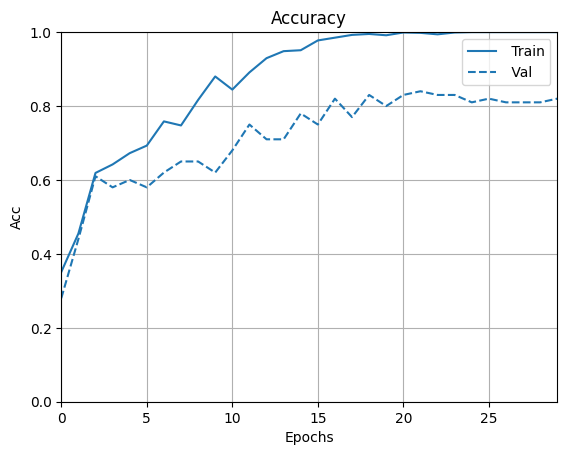

In [44]:
#!pip install tensorflow-docs
#Import the module after installing it.
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": new_history}, metric = "acc")
plt.title("Accuracy")
plt.ylim([0,1])

it indicates an overfitting immediately after the 5th epoch

(0.0, 1.0)

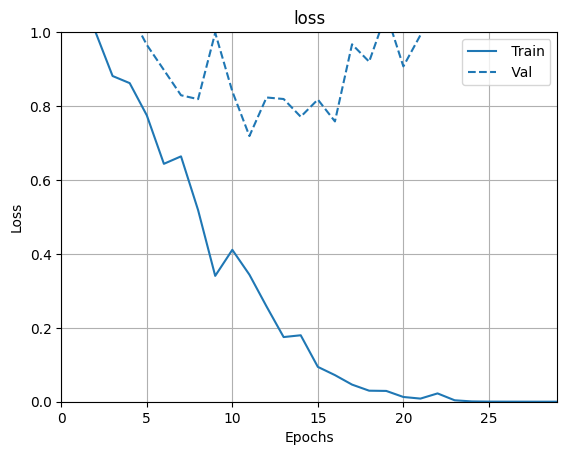

In [45]:
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"": new_history}, metric = "loss")
plt.title("loss")
plt.ylim([0,1])

It indicates an overfitting starting from the 5th epoch beacuse the the valdidation loss starts to increase immediatelty after the 5th epochs

In [ ]:
# Evaluating the model on the new test dataset
final_new_test_loss, final_new_test_accuracy = model_2.evaluate(new_test_ds)
print(f"Model Accuracy on New Test Data: {final_new_test_accuracy:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - acc: 0.5000 - loss: 7.1198
Model Accuracy on New Test Data: 0.50


In [46]:
import numpy as np
from sklearn.metrics import precision_score

# Get true labels and predictions for the new test dataset
y_true = []
y_pred = []

for images, labels in new_test_ds:
    predictions = model_2.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_classes)

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision for each class
precision_per_class = precision_score(y_true, y_pred, average=None)

# Print precision for each class
for i, precision in enumerate(precision_per_class):
    print(f"Class {i} Precision: {precision:.2f}")

# Calculate and print overall precision (weighted average)
overall_precision = precision_score(y_true, y_pred, average='weighted')
print(f"Overall Precision on New Test Data: {overall_precision:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
Class 0 Precision: 0.50
Class 1 Precision: 0.33
Class 2 Precision: 1.00
Class 3 Precision: 0.00
Class 4 Precision: 0.62
Overall Precision on New Test Data: 0.52


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In terms of the overall accuracy the result was 50% which indicates that the model performs moderately

The overall precision score of 0.52 (or 52%) suggests that the model’s general performance on the test dataset is moderate

In terms of precision for each class

Class 0 : 0.50 – Half of the predictions were correct. It indicates the model struggles somewhat in correctly identifying images.

Class 1 : 0.33 – Only one-third of the predictions were accurate, which indicates poor performance.

Class 2 : 1.00 – The model performed perfectly, meaning all predictions for this class were correct.

Class 3: 0.00 – The model failed to correctly predict any images leading to zero precision for this class.

Class 4: 0.62 – About 62% of the predictions for Class 4 were correct, showing reasonable but not perfect performance.

### Implementation of GNP(Gradient Norm Penalty)

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt

# model architecture
model_2 = new_model()

#  the base loss function
base_loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Optimizer
optimizer = optimizers.RMSprop(learning_rate=1e-4)

#  metric to track accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# I
epoch_loss = []
epoch_accuracy = []

# Custom training loop with gradient norm penalty
@tf.function
def train_step(images, labels):
    with tf.GradientTape(persistent=True) as tape:
        # Forward pass
        predictions = model_2(images, training=True)

        # Computing the base loss  for cross entropy
        loss = base_loss(labels, predictions)

        # Computing the gradients for the base loss
        gradients_for_penalty = tape.gradient(loss, model_2.trainable_variables)

        # Computing the L2 norm  (Gradient Norm Penalty)
        grad_norm = tf.sqrt(sum([tf.reduce_sum(tf.square(grad)) for grad in gradients_for_penalty]))

        # Add the gradient norm penalty to the base loss
        total_loss = loss + 0.1 * grad_norm  # 0.1 is the penalty coefficient

    # Computing gradients for total loss and update model weights
    gradients = tape.gradient(total_loss, model_2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_2.trainable_variables))

    # Update accuracy metric
    train_accuracy.update_state(labels, predictions)

    # Return total loss for tracking
    return total_loss

# Training loop to improve the model
epochs = 20
steps_per_epoch = 100

for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    step = 0
    train_accuracy.reset_state()
    epoch_loss_sum = 0

    for images, labels in new_train_ds.take(steps_per_epoch):
        step += 1
        loss = train_step(images, labels)
        epoch_loss_sum += loss.numpy()

        if step % 10 == 0:
            # Getting the current accuracy
            accuracy = train_accuracy.result().numpy()
            print(f"Step {step}/{steps_per_epoch}, Loss: {loss.numpy()}, Accuracy: {accuracy * 100:.2f}%")

    # Average loss for the epoch
    avg_epoch_loss = epoch_loss_sum / steps_per_epoch
    epoch_loss.append(avg_epoch_loss)

    # Accuracy at the end of the epoch
    final_epoch_accuracy = train_accuracy.result().numpy()
    epoch_accuracy.append(final_epoch_accuracy)
    print(f"Epoch {epoch + 1} Loss: {avg_epoch_loss:.4f}, Accuracy: {final_epoch_accuracy * 100:.2f}%")



Epoch 1/20


Step 10/100, Loss: 1.8005905151367188, Accuracy: 13.50%
Step 20/100, Loss: 1.7508718967437744, Accuracy: 22.25%
Step 30/100, Loss: 1.6887000799179077, Accuracy: 30.33%
Step 40/100, Loss: 1.689257264137268, Accuracy: 33.88%
Step 50/100, Loss: 1.755552887916565, Accuracy: 35.20%
Step 60/100, Loss: 1.6920140981674194, Accuracy: 37.00%
Step 70/100, Loss: 1.5458388328552246, Accuracy: 42.64%
Step 80/100, Loss: 1.389072299003601, Accuracy: 45.56%
Step 90/100, Loss: 1.3491191864013672, Accuracy: 46.39%
Step 100/100, Loss: 1.5005748271942139, Accuracy: 45.55%
Epoch 1 Loss: 1.7352, Accuracy: 45.55%
Epoch 2/20
Step 10/100, Loss: 1.5346611738204956, Accuracy: 55.00%
Step 20/100, Loss: 1.8364849090576172, Accuracy: 56.25%
Step 30/100, Loss: 1.4874385595321655, Accuracy: 47.83%
Step 40/100, Loss: 1.0020378828048706, Accuracy: 51.50%
Step 50/100, Loss: 2.0863711833953857, Accuracy: 48.90%
Step 60/100, Loss: 1.9865070581436157, Accuracy: 48.92%
Step 70/100, Loss: 1.0602049827575684, Accuracy: 51.21%


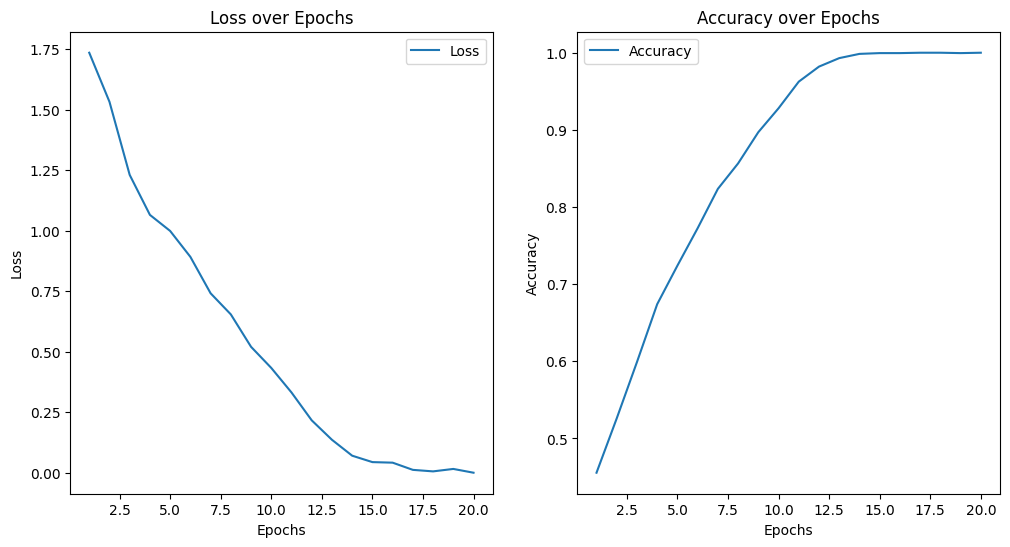

In [42]:
# Plotting loss and accuracy over epochs
plt.figure(figsize=(12, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), epoch_loss, label="Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), epoch_accuracy, label="Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

In [ ]:
# Evaluation on validation data
val_loss, val_acc = model_2.evaluate(new_test_ds, steps=50)
print(f"Validation Accuracy with GNP: {val_acc * 100:.2f}%")


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142us/step - accuracy: 0.5000 - loss: 6.3898
Validation Accuracy with GNP: 50.00%


In [ ]:
import numpy as np
from sklearn.metrics import precision_score

# Get true labels and predictions for the entire test da
true_labels = []
predicted_labels = []

for images, labels in new_test_ds.take(50):
    predictions = model_2(images, training=False)
    predicted_classes = tf.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision score
precision = precision_score(true_labels, predicted_labels, average='weighted')

# Print precision score
print(f"test Precision with GNP: {precision * 100:.2f}%")


test Precision with GNP: 51.19%


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
import numpy as np
from sklearn.metrics import precision_score

# Get true labels and predictions for the entire test dataset
true_labels = []
predicted_labels = []

for images, labels in new_test_ds.take(50):  # Adjust the steps as needed for your dataset
    predictions = model_2(images, training=False)
    predicted_classes = tf.argmax(predictions, axis=1)

    true_labels.extend(labels.numpy())
    predicted_labels.extend(predicted_classes.numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate precision score for each class
precision_per_class = precision_score(true_labels, predicted_labels, average=None, zero_division=0)

# Print precision for each class
for class_idx, precision in enumerate(precision_per_class):
    print(f"Class {class_idx} Precision: {precision * 100:.2f}%")


Class 0 Precision: 42.86%
Class 1 Precision: 33.33%
Class 2 Precision: 100.00%
Class 3 Precision: 0.00%
Class 4 Precision: 66.67%


In [ ]:
model.save('/content/drive/MyDrive/model_2.h5')

In [ ]:
from tensorflow.keras.models import load_model

#model_2 = load_model('/content/drive/MyDrive/gnp_model_2.h5')


Performance before GNP and after implementing GNP(gradient )

>Model Accuracy and Loss

>Before GNP:

Model accuracy on the new test data: 50%

Loss: 7.1198

The accuracy remained the same, and the loss slightly decreased, but the change is marginal, indicating that GNP did not improve the model's ability to generalize or learn significantly better.

-------------------------------

>Class-wise Precision

>Before GNP:

Class 0: 50%

Class 1: 33%

Class 2: 100%

Class 3: 0%

Class 4: 62%

---------------------------------
---------------------------------------
------------------------------------
>After GNP:

Model accuracy on the new test data: 50%

Loss: 6.3898

-----------------------------------


>Class-wise Precision

 >After GNP:

Class 0: 42.86%

Class 1: 33.33%

Class 2: 100%

Class 3: 0%

Class 4: 66.67%

The precision for Class 0 dropped from 50% to 42.86%, and Class 4 saw a small increase from 62% to 66.67%. The precision for Class 2 remained at 100%, but Class 3 still shows 0% precision, meaning the model is unable to correctly classify images from that class. The GNP was not effective at improving the overall distribution of class precision.

### Reasons Why GNP Is Not performing well

- Imbalanced Dataset:

Most times GNP helps by penalizing large gradients to prevent unstable learning, but this  dataset is showing a sign of imbalance.In this kind of situation GNP alone might not be enough to  address this. The model might not be getting enough representative data from all classes to learn the features needed to perform well across the board.

- GNP Helps More in Complex, Adversarial Training:

 generally GNP is  useful in more adversarial settings (like GANs) or when model has very unstable gradients during training. However, this model is not really suffering from highly unstable gradients but is major problem is actually overfitting.
In this kind of situation adding GNP might not make a significant difference.so this will make thw model architecture and training setup not to benefit much from GNP.

In addition as the GNP was not able to generalize well as shown from  accuracy and precision . This could suggest that the main issue is not gradient instability, but rather the quality of the data or the ability of the model to effectively learn from it.